## 1. Prepare Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, roc_curve, roc_auc_score

from aequitas.group import Group

In [2]:
X_train = pd.read_csv("X_train_oh.csv")

In [3]:
X_val = pd.read_csv("X_val_oh.csv")

In [4]:
X_test = pd.read_csv("X_test_oh.csv")

In [5]:
y_test = pd.read_csv("y_test.csv")

In [6]:
y_train = pd.read_csv("y_train.csv")

In [7]:
y_val =  pd.read_csv("y_val.csv")

In [8]:
y_test = np.array(y_test).ravel()
y_train = np.array(y_train).ravel()
y_val = np.array(y_val).ravel()

In [9]:
print(X_train.shape, X_val.shape, X_test.shape)

(794989, 50) (108168, 50) (96843, 50)


In [10]:
print(y_train.shape, y_val.shape, y_test.shape)

(794989,) (108168,) (96843,)


## 2. Define Matrics - performance & fairness

In [11]:
X_test["customer_age"]

0        40
1        30
2        40
3        30
4        20
         ..
96838    30
96839    30
96840    10
96841    30
96842    30
Name: customer_age, Length: 96843, dtype: int64

In [12]:
def Plot_ROC(fpr, tpr):
    plt.plot(fpr, tpr, label = 'ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [28]:
# focus on age group for now
from IPython.display import display
def Get_fairness_metrics(y_true, y_pred, groups, FIXED_FPR = 0.05):
    # aequitas.group
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": y_pred,
         "label_value": y_true,
         "group": groups}
    )
    # Use aequitas to compute confusion matrix metrics for every group.
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]
    #print("This is the disparities df:")
    #display(disparities_df)
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df

In [29]:
def Evaluation(predictions, ground_truth, X, FIXED_FPR=0.05):
    result = []
    fprs, tprs, thresholds = roc_curve(ground_truth, predictions) 
    Plot_ROC(fprs, tprs)
    
    tpr = tprs[fprs < FIXED_FPR][-1]
    fpr = fprs[fprs < FIXED_FPR][-1]
    threshold = thresholds[fprs < FIXED_FPR][-1]
    
    pd.set_option('display.max_columns', None)  # Show all columns
    
    
    print(f"threshold FPR: {round(fpr, 4)}")
    
    groups = (X["customer_age"] > 50).map({True: ">50", False: "<=50"})  # Define the group
    predictive_equality, disparities_df = Get_fairness_metrics(ground_truth, predictions, groups, FIXED_FPR)
    
    print("AUC:", roc_auc_score(ground_truth, predictions))
    print(f"TPR under the threshold: {round(tpr, 4)}")
    print(f"Predictive Equality: {round(predictive_equality, 4)}")
    
    result.append(round(tpr, 4))
    result.append(round(predictive_equality, 4))
    
    return result

## 3. Modeling

### 3.1 vanilla logistic model

In [15]:
lr_0 = LogisticRegression()
lr_0.fit(X_train, y_train)
y_pred = lr_0.predict_proba(X_test)[:,1]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


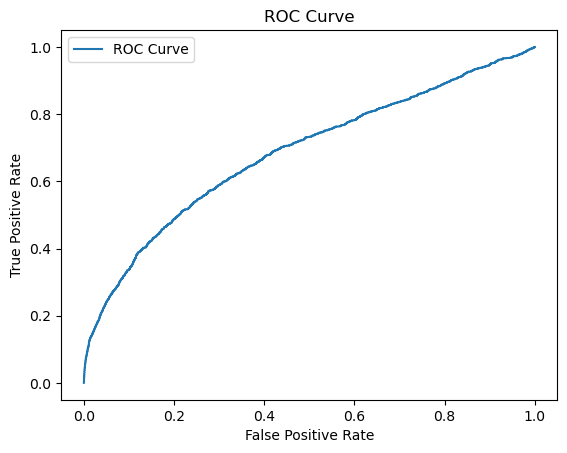

threshold FPR: 0.0497
This is the disparities df:


,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,0.05_val,48210,group,<=50,0.515628,0.712480,0.512938,0.007602,0.98040,0.487062,0.287520,0.992398,0.01960,46021,47880,0.954594,0.490101,45119,364,47516,902,1266,92635,93901,96843,0.013482
1,0,0.05_val,48210,group,>50,0.297417,0.876543,0.263669,0.026560,0.93513,0.736331,0.123457,0.973440,0.06487,2189,753,0.045406,0.744052,2047,20,733,142,162,2780,2942,96843,0.055065


AUC: 0.6848180387283562
TPR under the threshold: 0.2409
Predictive Equality: 0.6615


[0.2409, 0.6615]

In [16]:
Evaluation(y_pred, y_test, X = X_test)

### 3.2 logistic model change slover to 'newton-cholesky' as it performs good when sample >> features

In [17]:
lr_1 = LogisticRegression(solver = 'newton-cholesky')
lr_1.fit(X_train, y_train)
y_pred = lr_1.predict_proba(X_test)[:,1]

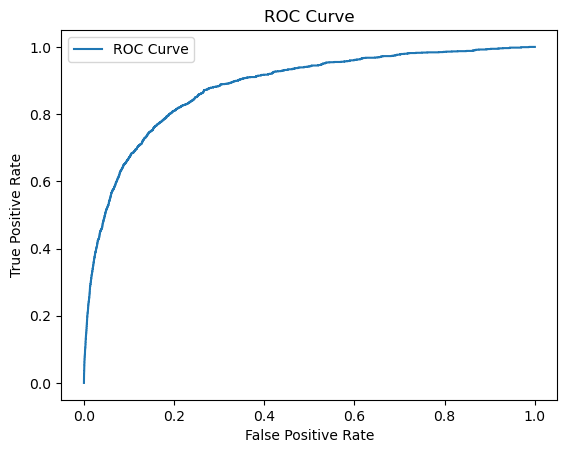

threshold FPR: 0.0498
This is the disparities df:


,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,0.05_val,2897,group,<=50,0.969053,0.358610,0.977395,0.008889,0.821821,0.022605,0.641390,0.991111,0.178179,2548,91353,0.879531,0.027135,2094,812,90541,454,1266,92635,93901,96843,0.013482
1,0,0.05_val,2897,group,>50,0.889531,0.574074,0.907914,0.026610,0.733524,0.092086,0.425926,0.973390,0.266476,349,2593,0.120469,0.118627,256,69,2524,93,162,2780,2942,96843,0.055065


AUC: 0.8799894490102284
TPR under the threshold: 0.5168
Predictive Equality: 0.2455


[0.5168, 0.2455]

In [18]:
Evaluation(y_pred, y_test, X = X_test)

### How to interpret this model?
As the author (Pedro Saleiro) of thr paper said, they are interested in finding the models with highest TPR above 0.8 predictive equality.

The lr_1 has a TPR of 50.14% and Predictive Equality of 31.42%, means the model is not ideal.

### 3-2. fine-tuned logistic model, with feature engineering and hyperparameter select.

In [19]:
# 1st, apply log transformation on X_train, X_test, and X_val dataset for [prev_address_months_count, current_address_months_count, days_since_request, intended_balcon_amount, bank_branch_count_8w, bank_months_count, session_length_in_minutes].
# Based on the EDA result in another ipynb, we apply log transformation on these highly right-skewed features.
features_to_log_transform = [
    'prev_address_months_count', 
    'days_since_request', 
    'intended_balcon_amount', 
    'bank_branch_count_8w', 
    'bank_months_count', 
    'session_length_in_minutes'
]

In [20]:
def log_transform(df, features):
    for feature in features:
        df[feature] = df[feature].apply(lambda x: np.log1p(x) if x >= 0 else x)
    return df

In [21]:
# apply log-transformation
X_train_transformed = log_transform(X_train.copy(), features_to_log_transform)
X_test_transformed = log_transform(X_test.copy(), features_to_log_transform)
X_val_transformed = log_transform(X_val.copy(), features_to_log_transform)

In [22]:
print(X_train_transformed.shape, X_test_transformed.shape, X_val_transformed.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(794989, 50) (96843, 50) (108168, 50)
(794989,) (96843,) (108168,)


In [23]:
# newton-cg
# newton-cholesky
lr_3 = LogisticRegression(solver = 'newton-cg')
lr_3.fit(X_train_transformed, y_train)
y_pred_3 = lr_3.predict_proba(X_test_transformed)[:,1]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


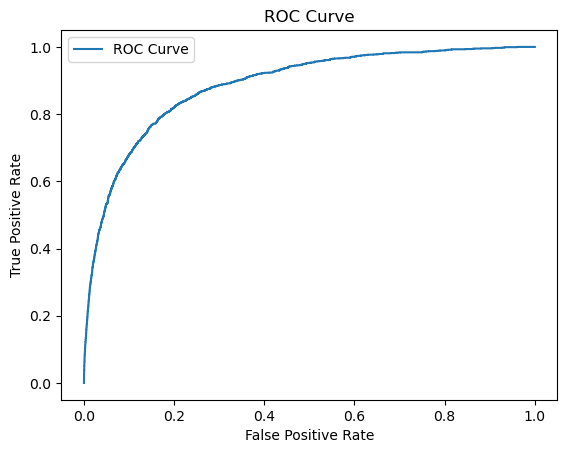

threshold FPR: 0.0496
This is the disparities df:


,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,0.05_val,3174,group,<=50,0.966848,0.385466,0.974794,0.008542,0.827134,0.025206,0.614534,0.991458,0.172866,2823,91078,0.889414,0.030064,2335,778,90300,488,1266,92635,93901,96843,0.013482
1,0,0.05_val,3174,group,>50,0.889531,0.580247,0.907554,0.026245,0.732194,0.092446,0.419753,0.973755,0.267806,351,2591,0.110586,0.119307,257,68,2523,94,162,2780,2942,96843,0.055065


AUC: 0.8863967826820505
TPR under the threshold: 0.5322
Predictive Equality: 0.2727


[0.5322, 0.2727]

In [24]:
Evaluation(y_pred_3, y_test, X = X_test_transformed)

A model is being trained


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


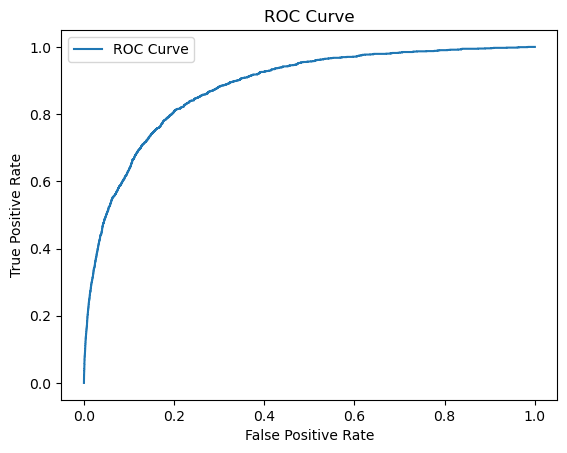

threshold FPR: 0.05
AUC: 0.8806742229440013
TPR under the threshold: 0.5021
Predictive Equality: 0.3309
curr best parameters: {'C': 0.005, 'max_iter': 100, 'solver': 'newton-cg'}
-----------------------------------
A model is being trained


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


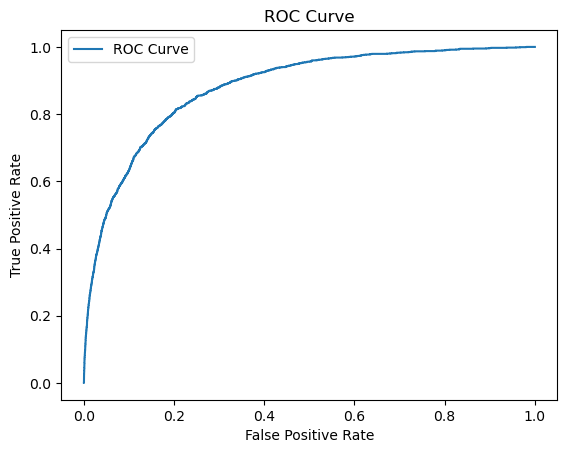

threshold FPR: 0.0499
AUC: 0.8807285007021406
TPR under the threshold: 0.5014
Predictive Equality: 0.3133
A model is being trained


KeyboardInterrupt: 

In [33]:
C_values = [0.005, 0.01, 0.015, 0.02]  # Regularization parameter
max_iter_values = [150, 200, 250, 300]    # Maximum number of iterations
available_slovers = ['newton-cg', 'newton-cholesky']

best_score = 0  
best_params = {}

# Iterate through hyperparameters
for C in C_values:
    for the_solver in available_solvers:
        for max_iter in max_iter_values:
            # Define and train Logistic Regression model with current hyperparameters
            print("A model is being trained")
            lr_model = LogisticRegression(solver=the_solver, C=C, max_iter=max_iter)
            lr_model.fit(X_train_transformed, y_train)
        
            y_pred_val = lr_model.predict_proba(X_val_transformed)[:, 1]
            # Current performance
        
            current_score = Evaluation(y_pred_val, y_val, X = X_val_transformed)[0]
            # Update best score and parameters if current model performs better
            if current_score > best_score:
                best_score = current_score
                best_params = {'C': C, 'max_iter': max_iter, 'solver':the_solver}
                print("curr best parameters:", best_params)
                print("-----------------------------------")


# Train the best model
best_lr_model = LogisticRegression(**best_params)
best_lr_model.fit(X_train_transformed, y_train)

# Make predictions with the best model
y_pred_2 = best_lr_model.predict_proba(X_test_transformed)[:, 1]

# Calculate the evaluation metric
evaluation_result = Evaluation(y_pred_2, y_test, X = X_test_transformed)[0]

# Print the best parameters and evaluation result
print("Best Parameters:", best_params)
print("Evaluation Result:", evaluation_result)

In [ ]:
# 0.01, 200, newton-cg
print("Best Parameters:", best_params)
print("Evaluation Result:", evaluation_result)